# ADC Crash Course!

An attempt to aggregate a bunch of lessons learned items from several decades of ADC applications.



**References to organize later:**

1. Maximum SNR vs. Clock Jitter:
https://www.analog.com/en/technical-articles/maximum-snr-vs-clock-jitter.html

2. On the Use of Windows for Harmonic Analysis With the Discrete Fourier Transform, Frederic Harris
https://www.researchgate.net/publication/2995027_On_the_Use_of_Windows_for_Harmonic_Analysis_With_the_Discrete_Fourier_Transform
3. "Taking the Mystery "SNR = 6.02N + 1.76dB," and Why You Should Care" (EVEN THOUGH with most modern converters you shouldn't care 🙂 ) https://www.analog.com/media/en/training-seminars/tutorials/mt-001.pdf 



# Introduction
Simulation of basic FFT operation, SNR calculation
Basically, we're making a vector of N time domain
samples, then corrupting the signal in several "real world" ways:

1.   Thermal noise is added to the signal, which is just a random
number with a gaussian distribution. This is often referred to as the
"transition noise" of an ADC, and it can never be smaller than K*T/C where
K is Boltzmann's constant, T is absolute temperature, and C is the size of the
ADC's sample capacitor.
2.   Quantization noise is added by simply starting with a signal of amplitude
2^(number of bits), then truncating the decimal portion with the int function.
3. Random jitter is added to the sample clock. This is an accurate model of
wideband clock jitter that is spread across seveal Nyquist bands
4. Deterministic jitter is added to the sample clock, representing phase noise
at a particular frequency. This gives an intuitive understanding of the effect
of phase noise as a signal's frequency and amplitude change.

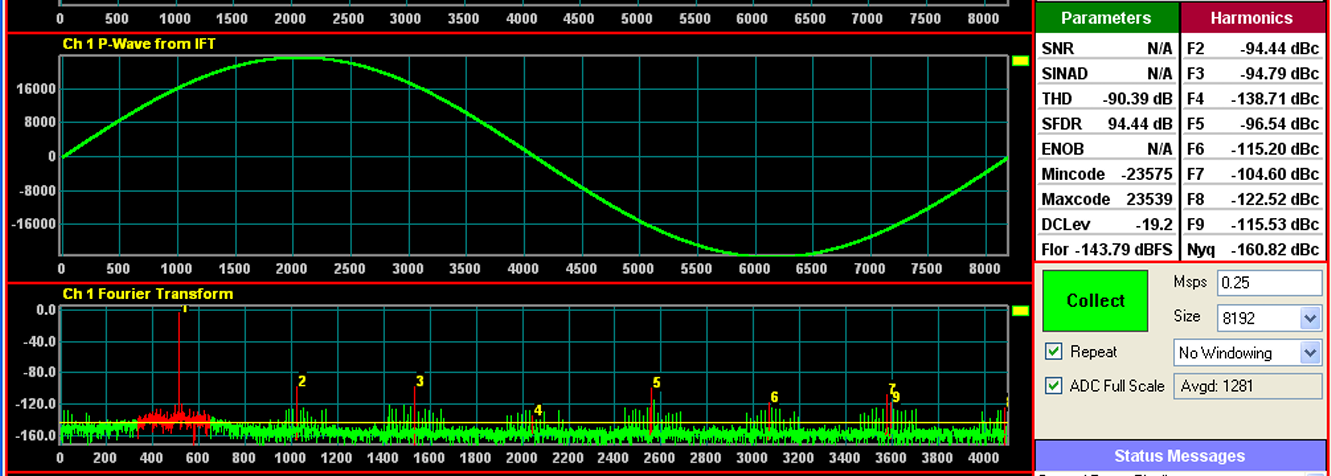

In [3]:
# Still struggling with getting interactive plots to work. From Travis' notes:
# Try Plotly, Streamlet, Dash.
# ipymply is a dependency for the matplotlib widget backend:
# !pip install ipympl

In [4]:

# Okay, let's get started.
# Pull in the good stuff from various libraries...
import numpy as np
from scipy import fft
from matplotlib import pyplot as plt
# from google.colab import output
# output.enable_custom_widget_manager()
#from google.colab import output
#output.enable_custom_widget_manager()


'''############################'''
'''Set up simulation parameters'''
'''############################'''
# There are a few ways that we could express sample rates and frequencies -
# Samples per second for sample rate, Hz for signal frequency, etc. For the sake of
# conveneience let' start by thinking in terms of normalized sample rate of unity (one smample per second, for example)
# Then the FFT output will span from zero (DC) to half the sample rate (or 0.5 cycles per sample)

# If the idea of FFT "bins" is confusing, now might be a good time to do some 
# YouTubing on FFTs. And eventually, we'll get this "deconstructed FFT" moved over to Colab:
# https://github.com/mthoren-adi/ROUS/blob/master/educational/illustrated_fft.py

# But fundamentally - an FFT will take a set of time domain samples and produce an output
# in the frequency domain. Each "bin" represents an EXACT frequency - the first bin (bin 0)
# is zero frequency (DC), the second bin (bin 1) is fs/N, where:
# fs is the sample rate
# N is the number of points in the input data.

fs = 100000
""" We're not going to use this just yet, but let's pick a sample rate,
somewhat arbitrarily. We'll use 100ksps because it will comfortably digitize audio,
and when we get to talking to actual hardware, we'll be able to listen to the experiments.
More senses excited = BETTER! """

N = 4096 
""" Number of data points in the input record. The classic FFT requires a power of 2
number of data points. This will also be the number of points in the FFT output."""

bin_number = 100 
""" Bin number of the signal itself. If bin_number is greater
than N/2, then the signal will be aliased accordingly.
For now, stick with integer bin numbers. Or better yet, experiment around
with non-integers (like 500.1, 500.2, 123.45, etc.) and note 
what happens to the FFT plot (Yuck!)"""

print("Sample Rate: ", fs, " samples per second")
print("Input frequency: ", fs * bin_number / N, " Hz")

bits = 16
""" ADC resolution (Theoretical!!)
This determines the quantization noise of the converter. 
If you set all of the following imperfections to zero (or close to it),
you should see an SNR of about N * 6.02 + 1.78 dB"""

vref = 5.0
signal_lvl = 5.0
""" Define a typical reference voltage and signal level to make this a bit more tangible.
Remember that an ADC performs the function of division:
Output code = (input voltage / reference) * 2^bits
We'll start out with a 5V reference, and signal level is peak-to-peak such that the ADC
is at full-scale when it's equal to the reference (not RMS, not amplitude, etc.) """

thermal_noise_lvl = 0.0001 * vref / 2**bits #0.00010 # LSB of thermal noise
print("thermal noise level (uV): ", thermal_noise_lvl * 1e6)
jitter_lvl = 0.000001 #0.000025 # clock jitter, expressed as RMS fraction of a sampling interval

# Now for some phase noise... To illustrate the concept, we're going to introduce
# a single tone of phase noise, rather than a distribution (as is the case in
# "real life".) This IS an accurate representation of a sinusoidal disturbance
# on the clock.
phase_noise_offset = 25 # Offset from carrier in bins
phase_noise_lvl = 0.0001 #.000001 #Amplitude, in fraction of a sample period
'''##############################'''
'''END set up simulation parameters'''
'''##############################'''
print("Parameter Setup Done.")

Sample Rate:  100000  samples per second
Input frequency:  2441.40625  Hz
thermal noise level (uV):  0.00762939453125
Parameter Setup Done.


In [ ]:
# declare variables to make code easier to read below
signal = np.zeros(N)
thermal_noise = np.zeros(N)
signal_and_noise = np.zeros(N)
adc_output = np.zeros(N)

freq_domain_signal = np.zeros(N)
freq_domain_noise = np.zeros(N)

signal_amplitude_p_p = 2.0**bits # Calculated amplitude in LSB.

#Generate some input data, along with noise
for t in range(N):
    phase_jitter = phase_noise_lvl * np.cos(2.0 * np.pi * phase_noise_offset* t / N)
    samp_jitter = np.random.normal(0.0, jitter_lvl)
    signal[t] = (signal_lvl / 2.0) * np.cos(2.0*np.pi*bin_number*(t + samp_jitter + phase_jitter)/N) #First the pure signal with jitter effects :)
    thermal_noise[t] = np.random.normal(0.0, thermal_noise_lvl) #Then the thermal noise ;(
    signal_and_noise[t] = signal[t] + thermal_noise[t]
    adc_output[t] = np.rint((signal_and_noise[t] / vref) * 2**bits) #Finally, round to integer value - equiavalent to quantizing

freq_domain = np.fft.fft(adc_output)
freq_domain_magnitude = np.abs(freq_domain)/N

#Now notch the signal out of the spectrum. We have the advantage here
#that there's only a single bin of signal, and no distortion.
np.copyto(freq_domain_noise, freq_domain_magnitude) #Make a copy
freq_domain_noise[bin_number] = 0 #Zero out positive signal bin
freq_domain_noise[N - bin_number] = 0 # And the negative bin
# Note that we're also zeroing out one bin worth of noise. We're going to assume this is insignificant
# in this simulation, but if you're zeroing out lots of bins with a mask, you might want to fill them in
# with the average noise floor from the bins that aren't zeroed
# (or some more intelligent estimate if the noise floor is wiggling around.)

#Make another array that just has the signal
freq_domain_signal[bin_number] = freq_domain_magnitude[bin_number]
freq_domain_signal[N - bin_number] = freq_domain_magnitude[N - bin_number]

signal = 0.0 #Start with zero signal, zero noise
noise = 0.0

# Sum the power root-sum-square in each bin. Abs() function finds the power, a resistor dissipating
# power does not care what the phase is!

signal_ss = np.sum(((freq_domain_signal)) ** 2)
noise_ss = np.sum(((freq_domain_noise)) ** 2 )

signal = np.sqrt(signal_ss)#  / N
noise = np.sqrt(noise_ss) # / N

snr_fraction = signal / noise
snr = 20*np.log10(signal / noise)
print ("Signal: " + str(signal))
print ("Noise: " + str(noise))
print ("Fractional signal to noise: " + str(snr_fraction))
print ("SNR: " + str(snr) + "dB")
print ("Theoretical SNR based on 6.02*bits + 1.76: ", (6.02 * bits) + 1.76)

max_freq_domain_magnitude = max(freq_domain_magnitude)
freq_domain_magnitude_db = 20 * np.log10(freq_domain_magnitude / max_freq_domain_magnitude)

In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

#%matplotlib widget
plt.close('all')
plt.figure(1)
plt.title("Time domain data, with imperfections")
plt.xlabel("Sample Number")
plt.ylabel("ADC counts")
plt.plot(adc_output)
plt.xlim(0, 100)
plt.show

plt.figure(2)
plt.title("Spectrum")
plt.xlabel("FFT Bin")
plt.ylabel("Signal Level, dBC")
plt.plot(freq_domain_magnitude_db)
# plt.xlim(0, 500) # Uncomment to manually zoom
plt.show

Alrighty, that was a nice warmup! we've compared a single bin worth of signal to the rest of bins as noise, and plotted out the FFT. But why is the FFT output "mirrored"? Remember that the output of an FFT has the same number of points as the input data, and bin 1 represents a frequency of fs/N. Visually, this is a sinewave that covers a single cycle over the entire time record. And from Nyquist, the FFT output can only digitize to fs/2, which is the center of the FFT. The right-hand side of the FFT is thus a mirroring of the left side, from fs/2 back to DC. Sort of. It's more accurate to think of it as INCREASING in frequency from fs/t UP to fs! Remember that a signal at fs... will ALIAS to DC!

Another important concept - both the input and output of an FFT are complex. It just happens that if you only stuff real values into the FFT input, the outputs will be complex conjugates mirrored around fs/2. That's a mouthful, so let's take a look at a couple of examples from the data above:

In [ ]:
# Pick a bin, any bin (from 1 to N/2)
test_bin = 1000
print(freq_domain[test_bin])
print(freq_domain[N-test_bin])
print("Check it out... real parts should be equal, imaginary equal and opposite sign...")

With that out of the way, let's button up our method of plotting FFTs - when we're working with only real samples (vs. complex, as in an I/Q radio signal), we can simply look at bins 0 to N/2-1, and double each bin. Any real valued signal that exceeds fs/2 will simply alias back into the range of DC to fs/2.

# Windowing
Although it might not have seemed significant at first glance, the biggest simplification in the introductory example is that we parked the fundamental signal at an exact FFT bin. In fact - we DEFINED the signal frequency in terms of FFT bin, then calculated what its actual frequency was based on the sample rate and number of data points.

In reality - this situation is surprisingly difficult to achieve in real life: it requires two signal sources - one to set the sample rate (often called the "clock") and another to generate the analog input signal. They both must be stable, and at least one of them must have very fine frequency resolution (we'll define HOW fine shortly...). Furthermore, they either need to be extraordinarily accurate (like, rubidium frequency standard accurate), OR more realistically (and lower cost), both sharing the same frequemcy reference. Often benchtop synthesizers will have a 10MHz reference input, output, or both, as BNC jacks on the back panel.

What happens if you're not on an exact frequency bin? Well, you end up with a partial cycyle of the fundamental signal in the data record, and the fundamental "leaks" all over the spectrum. Let's get a picture of how bad it can get:

https://www.gaussianwaves.com/2020/09/window-function-figure-of-merits/

In [ ]:
""" First, let's Button up a few utility functions. """

import numpy as np

def create_signal(N, bin_number, bits, vref, signal_lvl, thermal_noise_lvl, jitter_lvl, phase_noise_lvl, phase_noise_offset, randomize_phase = False):
    """ Create simulated ADC output """
#    import numpy as np
    signal = np.zeros(N)
    thermal_noise = np.zeros(N)
    signal_and_noise = np.zeros(N)
    adc_output = np.zeros(N)

    freq_domain_signal = np.zeros(N)
    freq_domain_noise = np.zeros(N)

    if randomize_phase:
        phase = np.random.random()* 2.0 * np.pi
    else:
        phase = 0.0

    #Generate some input data, along with noise
    for t in range(N):

        phase_jitter = phase_noise_lvl * np.cos(2.0 * np.pi * phase_noise_offset* t / N)
        samp_jitter = np.random.normal(0.0, jitter_lvl)
        signal[t] = (signal_lvl / 2.0) * np.cos(phase + (2.0*np.pi*bin_number*(t + samp_jitter + phase_jitter)/N)) #First the pure signal with jitter effects :)
        thermal_noise[t] = np.random.normal(0.0, thermal_noise_lvl) #Then the thermal noise ;(
        signal_and_noise[t] = signal[t] + thermal_noise[t]
        adc_output[t] = int((signal_and_noise[t] / vref) * 2**bits) #Finally, round to integer value - equiavalent to quantizing
        #adc_output[t] = ((signal_and_noise[t] / vref) * 2**bits) #Finally, round to integer value - equiavalent to quantizing
    return(adc_output)



def plot_time_and_freq(t, f):
    """Basic plotting routine for time and frequency"""
    from matplotlib import pyplot as plt
    plt.close('all')
    plt.figure(1)
    plt.title("Time domain data, with imperfections")
    plt.xlabel("Sample Number")
    plt.ylabel("ADC counts")
    plt.plot(t)
    #plt.xlim(0, 100)
    plt.show

    plt.figure(2)
    plt.title("Spectrum")
    plt.xlabel("FFT Bin")
    plt.ylabel("Signal Level, dBC")
    plt.plot(f)
    plt.xlim(0, 100) # Uncomment to manually zoom
    plt.show

def calculate_spectrum_dbc(data, ref = None, dBc = True):
    """ Calculate spectrum in dB releative to the carrier. """
    freq_domain = np.fft.fft(data)
    freq_domain_magnitude = (2.0*np.abs(freq_domain)/len(data))[:len(data)//2]
    max_freq_domain_magnitude = np.max(freq_domain_magnitude)
    if ref is None:
        ref = max_freq_domain_magnitude
    freq_domain_magnitude_db = 20 * np.log10(freq_domain_magnitude / ref)
    return freq_domain_magnitude_db



In [ ]:
""" Do some experimentation here - let's leave the bin number at 50.0050,
    which is a 100ppm departure from exactly bin 50. Try 1ppm departures, 1000ppm, etc.
    to get a feel for just how perfect you need to be to get an accurate measurement
    of the fundamental with no leakage.
    
    Also note that the phase is randomized so you should be able to run this cell
    over and over again, and see how the leakage "dances" around :)
    """

time_domain = create_signal(4096, 50.0050, 16, 1.0, 1.0, 0.00001, 0.0, 0.0, 0.0, randomize_phase=True)
print("Here's a few samples: ", time_domain[0:8])

freq_domain_magnitude_db = calculate_spectrum_dbc(time_domain, ref = 2 ** 16)

print("Here's a few bins: ", freq_domain_magnitude_db[48:53])

plot_time_and_freq(time_domain, freq_domain_magnitude_db)

In [ ]:
""" So how the heck do we mitigate this effect? the answer is "windowing".
    """

time_domain = create_signal(4096, 50.0050, 16, 1.0, 1.0, 0.00001, 0.0, 0.0, 0.0, randomize_phase=True)
print("Here's a few samples: ", time_domain[0:8])

window = np.blackman(len(time_domain))

windowed_time_domain = time_domain * window

freq_domain_magnitude_db = calculate_spectrum_dbc(windowed_time_domain, ref = 2 ** 16)

print("Here's a few bins: ", freq_domain_magnitude_db[48:53])

plot_time_and_freq(windowed_time_domain, freq_domain_magnitude_db)

**To Cover Next:**


*   Different types of windows and their figures of merit
*   Interpreting windowed FFT data - how to sum power across a few bins, etc.
*   SNR/THD calculations, locating harmonics, figuring out what to count as signal, noise, and harmonics.
*   Masking out regions of the noise floor that we know can't be blamed on the ADC (automasking in Pscope)
*   Video (scalar) averaging to smooth out the noise floor
*   Vector averaging to reduce noise floor while accurately measuring harmonically related components



# Talking to Hardware (Warmup)

In [ ]:
# Okay now let's talk to some hardware!

# Here's how to connect to a local runtime:
# https://research.google.com/colaboratory/local-runtimes.html
# And after doing so, this actually works!!:
# For reference:
# pip install --upgrade jupyter_http_over_ws>=0.0.7 && jupyter serverextension enable --py jupyter_http_over_ws

# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com'  --port=8888  --NotebookApp.port_retries=0


# It looks like installing from pip works fine, but...
# shouldn't need to do here if the Jupyter environment is set up properly.
# !pip install pyadi-iio

import adi
print("ADI path:")
print(adi.__file__)
print("ADI objects:")
print(dir(adi))



In [ ]:
# Warmup for seeing if we can talk to hardware here...
# Note that you need to have a Pi with an LM75 attached somewhere on your network
my_uri = "ip:experimenter.local" # "experimenter" is Thoren's "always-on" hacker board
my_temp_sensr = adi.lm75(uri=my_uri)

print("\nChecking temperature channel...")
print("Temperature raw: " + str(my_temp_sensr.input))
print(
    "Temperature in deg. Celsius: " + str(my_temp_sensr.to_degrees(my_temp_sensr.input))
)

print("\nUpdate interval: " + str(my_temp_sensr.update_interval))


print("\nMax threshold: " + str(my_temp_sensr.to_degrees(my_temp_sensr.max)))
print("Max hysteresis: " + str(my_temp_sensr.to_degrees(my_temp_sensr.max_hyst)))

print("\nSetting max threshold, hyst. to 30C, 25C...\n")

my_temp_sensr.max = my_temp_sensr.to_millidegrees(30.0)
my_temp_sensr.max_hyst = my_temp_sensr.to_millidegrees(25.0)

print("New thresholds:")
print("Max: " + str(my_temp_sensr.to_degrees(my_temp_sensr.max)))
print("Max hysteresis: " + str(my_temp_sensr.to_degrees(my_temp_sensr.max_hyst)))

del my_temp_sensr

# Talkigng to Hardware (Actual ADC data)

Okay, now that we've successfully talked to a basic sensor, let's grab some data from an actual ADC!

In [ ]:
'''
NOTE: At the moment, the LTC2387 interface is in this branch:
https://github.com/mthoren-adi/pyadi-iio/tree/ltc2387_dev

'''


import numpy as np
from scipy import signal

device_name = "ltc2387"

# Optionally passs URI as command line argument,
# else use default context manager search
my_uri = sys.argv[1] if len(sys.argv) >= 2 else None
print("uri: " + str(my_uri))

my_adc = adi.ltc2387(uri=my_uri)
my_adc.rx_buffer_size = 4096
my_adc.sampling_frequency = 10000000

data = my_adc.rx()

# Figure out how to do this correctly - need to sign extend bit 17
for i in range(len(data)):
    if data[i] > 2 ** 17:
        data[i] -= 2 ** 18

x = np.arange(0, len(data))
plt.figure(1)
plt.clf()
plt.plot(x, data)
plt.show()

f, Pxx_den = signal.periodogram(data, my_adc.sampling_frequency, window="blackman")

plt.figure(2)

plt.clf()
plt.semilogy(f, Pxx_den)
plt.ylim([1e-5, 1e5])
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.draw()
plt.pause(0.05)

del my_adc

Next Steps:
1. Run sin_params analysis
2. Pick apart analysis, cover windowing, summing signal, noise, and harmonic power